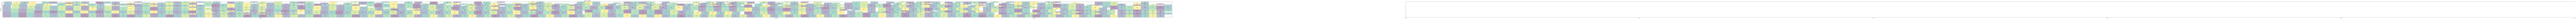

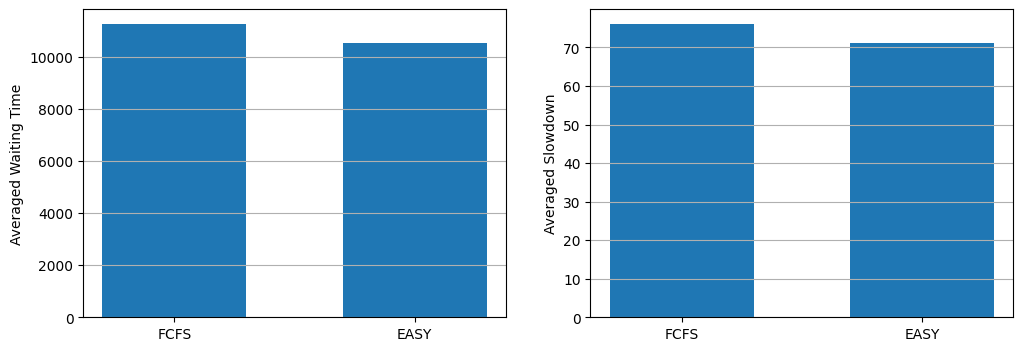

In [26]:
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt
import pandas as pd

def visualize_avg_waiting_time(sim_fcfs, sim_easy):
    sim_fcfs['name'], sim_easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([sim_fcfs, sim_easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_fcfs, jobs_easy):

    _, ax_list = plt.subplots(1, 2, sharey=True, figsize=(650, 4))
    # plot_gantt(jobs_fcfs, ax=ax_list[0], title="FCFS Scheduler")
    plot_gantt(jobs_easy, ax=ax_list[0], title="EASY Scheduler")

    plt.ylim(ymin=0, ymax=16)
    plt.yticks(list(range(16)))
    plt.show()


jobs_fcfs = pd.read_csv('results/batsim/fcfs_jobs.csv')
jobs_fcfs['job_id'] = jobs_fcfs['job_id'].astype(str)  
jobs_fcfs['profile'] = jobs_fcfs['profile'].astype(str)
jobs_fcfs = pd.DataFrame(jobs_fcfs)
jobs_fcfs['allocated_resources'] = jobs_fcfs['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_fcfs = JobSet(jobs_fcfs)


jobs_easy = pd.read_csv('results/batsim/easy_jobs.csv')
jobs_easy['job_id'] = jobs_easy['job_id'].astype(str)
jobs_easy['profile'] = jobs_easy['profile'].astype(str) 
jobs_easy = pd.DataFrame(jobs_easy)
jobs_easy['allocated_resources'] = jobs_easy['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy = JobSet(jobs_easy)

sim_fcfs = pd.read_csv('results/batsim/fcfs_sims.csv')
sim_fcfs = pd.DataFrame(sim_fcfs)

sim_easy = pd.read_csv('results/batsim/easy_sims.csv')
sim_easy = pd.DataFrame(sim_easy)

visualize_schedule(jobs_fcfs, jobs_easy)
visualize_avg_waiting_time(sim_fcfs, sim_easy)

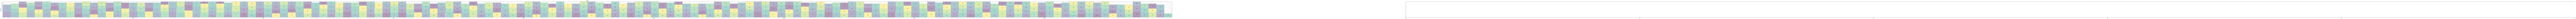

In [27]:
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt
import pandas as pd

def visualize_avg_waiting_time(jobs_f, sim_f, jobs_e, sim_e):
    fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

    fcfs, easy = JobSet(fcfs), JobSet(easy)

    fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
    fcfs['name'], easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([fcfs, easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_easy):

    _, ax_list = plt.subplots(1, 2, sharey=True, figsize=(650, 4))
    # plot_gantt(jobs_fcfs, ax=ax_list[0], title="FCFS")
    plot_gantt(jobs_easy, ax=ax_list[0], title="EASY")

    plt.ylim(ymin=0, ymax=16)
    plt.yticks(list(range(16)))
    plt.show()

# jobs_fcfs = pd.read_csv('results/sp/fcfs_jobs.csv')
# jobs_fcfs['job_id'] = jobs_fcfs['job_id'].astype(str)  
# jobs_fcfs['profile'] = jobs_fcfs['profile'].astype(str)
# jobs_fcfs = pd.DataFrame(jobs_fcfs)
# jobs_fcfs['allocated_resources'] = jobs_fcfs['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
# jobs_fcfs = JobSet(jobs_fcfs)

jobs_easy = pd.read_csv('results/sp/easy_jobs.csv')
jobs_easy['job_id'] = jobs_easy['job_id'].astype(str)  
jobs_easy['profile'] = jobs_easy['profile'].astype(str)
jobs_easy = pd.DataFrame(jobs_easy)
jobs_easy['allocated_resources'] = jobs_easy['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy = JobSet(jobs_easy)

visualize_schedule( jobs_easy)

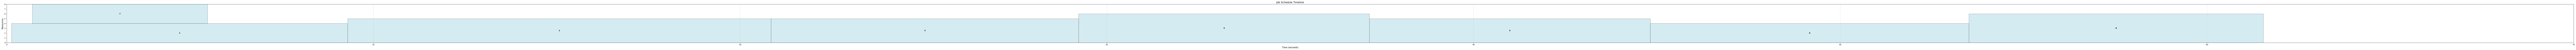

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

jobs = [
    {"job_id": 1, "start": 0.1294, "end": 9.2984, "resources": "0-3"},
    {"job_id": 7, "start": 0.6977, "end": 5.4738, "resources": "4-7"},
    {"job_id": 2, "start": 9.2984, "end": 20.8415, "resources": "0-4"},
    {"job_id": 3, "start": 20.8415, "end": 29.2302, "resources": "0-4"},
    {"job_id": 4, "start": 29.2302, "end": 37.1584, "resources": "0-5"},
    {"job_id": 5, "start": 37.1584, "end": 44.8181, "resources": "0-4"},
    {"job_id": 6, "start": 44.8181, "end": 53.5077, "resources": "0-3"},
    {"job_id": 8, "start": 53.5077, "end": 61.5360, "resources": "0-5"},
]

fig, ax = plt.subplots(figsize=(200, 4))

# Calculate maximum end time and round up to nearest 10
max_end = max(job['end'] for job in jobs)
max_x = np.ceil(max_end / 10) * 10

for job in jobs:
    # Parse resource range
    res_start, res_end = map(int, job['resources'].split('-'))
    height = res_end - res_start + 1
    
    # Create rectangle
    rect = Rectangle(
        (job['start'], res_start),
        job['end'] - job['start'],
        height,
        edgecolor='black',
        facecolor='lightblue',
        alpha=0.5
    )
    ax.add_patch(rect)
    
    # Add job ID text
    x_center = job['start'] + (job['end'] - job['start']) / 2
    y_center = res_start + height / 2
    ax.text(x_center, y_center, str(job['job_id']),
            ha='center', va='center', fontweight='bold')

# Set axes limits and ticks
ax.set_ylim(0, 8)
ax.set_yticks(np.arange(0, 9))
ax.set_xlim(0, max_x)
ax.set_xticks(np.arange(0, max_x + 1, 10))

# Add labels and grid
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Resources', fontsize=12)
ax.set_title('Job Schedule Timeline', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()